In [1]:
#IN google colab install abtem and pycu for gpu acceleration:
#!pip install abtem
#!pip install pycu

%matplotlib inline

from abtem import __version__
print('current version:', __version__)

import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

from abtem import *
from abtem.structures import orthogonalize_cell

from ase.spacegroup import crystal

from ase.visualize import view

from abtem.transfer import scherzer_defocus
import numpy as np

import matplotlib.pyplot as plt

from abtem.utils import fft_shift
from abtem.aperture import DeviatedAnularAperture
from abtem.aperture import DeviatedAperture
import scipy.constants as c

from collections import defaultdict

from abtem.transfer import cartesian2polar
from abtem.transfer import Haider2Krivanek

current version: 1.0.0beta27


In [2]:
def imshow(X, *args, **kwargs): # it seems so that reciprocal arrays (phi or alpha or result of evaluating ctf or aperture) are transformed so that it is neccessary to firstly use fftshift and then mirror the values along axis=0. In arrays which are in direct space (probe image) via probe.build().intensity().array[0] it suffices only to morror the image along axis=0. 
    return plt.imshow(X=np.flip(X,axis=0),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(X,0,1),*args, **kwargs)
    #return plt.imshow(X=np.swapaxes(np.flip(X,axis=0),0,1),*args, **kwargs)

# SrTiO$_3$

We build an atomic structure of MoS2 with ASE. Since abTEM requires an orthogonal we make the cell orthogonal. We also need to repeat the structure, so the probe fits inside the cell.

<AxesSubplot:title={'center':'Side view'}, xlabel='x [Å]', ylabel='z [Å]'>

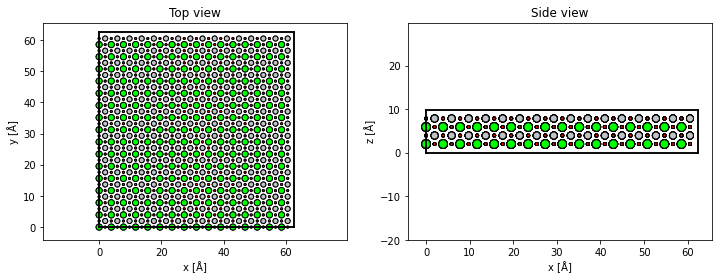

In [3]:
atom_pos = [(0.0, 0.0, 0.0), (0.5, 0.5, 0.5), (0.5, 0.5, 0.0)]
srtio3 = crystal(['Sr','Ti','O'], atom_pos, spacegroup=221, cellpar=3.905, size=(1, 1, 2))
atoms = srtio3

repetitions = (16, 16, 1)

atoms = orthogonalize_cell(atoms)

atoms *= repetitions

atoms.center(vacuum=2, axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

show_atoms(atoms, ax=ax1, title='Top view')
show_atoms(atoms, ax=ax2, plane='xz', title='Side view')

In [4]:
#view(atoms)

In [5]:
print(f"Simulation cell: {atoms.cell}")

Simulation cell: Cell([62.48, 62.48, 9.8575])


We create and calculate the electrostatic potential.

In [6]:
gpts=512
potential = Potential(atoms, 
                      gpts=gpts,
                      projection='finite', 
                      slice_thickness=1, 
                      parametrization='kirkland')

potential = potential.build()

10

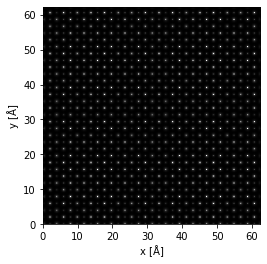

In [7]:
potential.project().show()
len(potential)

In [8]:
print(f"Real space sampling: {potential.sampling}")

Real space sampling: (0.12203125, 0.12203125)


In [9]:
def get_coeffs(C1,A1,C3,B2=0*1j,A2=0+0*1j): #parameters in argumentC1,A1,.. are original values of aberations in [m]
    A0=0+0*1j
    cartesian = Haider2Krivanek(C1,A1,C3,B2,A2)
    return(A0.real/1e-10,A0.imag/1e-10,cartesian2polar(cartesian)) #returning in angstrems

In [10]:
energy=200e3
phi_star=energy*(1-c.elementary_charge*energy/2/c.m_e/c.c**2)

#temporal coherrence
Cc=1.61e-3/1e-10 # In Angstrem
focal_spread=Cc*(0.6/200e3)

#spatial coherrence
reduced_brightness=1e8 
d=0.6*2*1e-10 # from graph below with C3=0 
I=0.2e-9
alphaa=np.sqrt(4*I/np.pi**2/d**2/reduced_brightness/phi_star)
beta=1/np.e*alphaa*1e3#1/e of angle distribution in [mrad]
angular_spread=beta


_, _, aberations_dict = get_coeffs(C1=0,A1=0,C3=1.9e-3)
defocus_0=scherzer_defocus(Cs=aberations_dict["C30"],energy=energy) 

In [11]:
semiangle_cutoff=9.5

In [12]:
aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,inner_aperture_angle=0,spokes=0,spoke_thickness=0)
probe = Probe(energy=energy, aperture=aperture, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])#, angular_spread=angular_spread,focal_spread=focal_spread)

To run this simulation using PRISM instead of the standard multislice algorithm, uncomment the cell below. Note that while PRISM may be up to a 1000 times faster than multislice for large structures, the performance is fairly similar for small simulations like this.

In [13]:
#probe = SMatrix(energy=energy, semiangle_cutoff=11.3, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])
#probe = SMatrix(energy=energy, semiangle_cutoff=9.5, expansion_cutoff=20, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"],angular_spread=angular_spread,focal_spread=focal_spread)
#_, _, aberations_dict = get_transformed_coeffs(C1=-defocus_0*1e-10,A1=0,C3=1.9e-3,delta=0e-3+0*1j) 
#probe.ctf.set_parameters(aberations_dict)

In [14]:
print("defocus_0: ",defocus_0)
print("angular_spread: ",angular_spread)
print("focal_spread: ",focal_spread)

defocus_0:  845.4355085066284
angular_spread:  6.881673166871456
focal_spread:  48.300000000000004


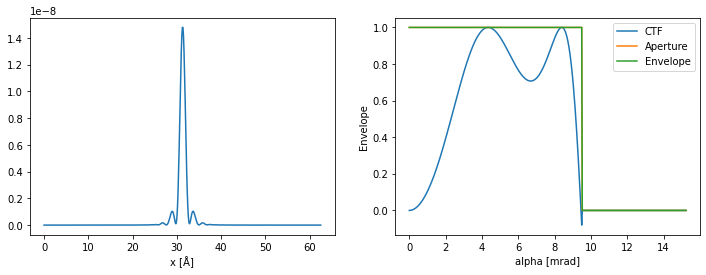

In [15]:
probe.grid.match(potential)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

probe.profile().show(ax=ax1);

probe.ctf.show(ax=ax2);

In [16]:
#Calculate radial intensity of probe and cumulative radial intensity for estimate of probe diameter (at 50% of current)

In [17]:
#Following is wrong... imprecise and non general.. width of probe without abberations ... Cs=0 and with cohherent image (partial cohherence is turned off) ... was arout 4 times larger then in implementation below
if False:
    calibration=probe.profile().calibrations[0]
    y = probe.profile().array #it is already intensity
    x = np.linspace(calibration.offset, calibration.offset + len(y) * calibration.sampling, len(y))
    x = x-calibration.sampling*len(y)/2

    y_cropped = y[x >= 0]
    x_cropped = x[x >= 0]

    plt.plot(x,y)
    plt.xlabel(r"$x$ [$\mathrm{\AA}$]")
    plt.ylabel(r"intensity I(x) [arb. unit]")

    radial_intensity = y_cropped * x_cropped**2 

    fig, ax1 = plt.subplots() 

    plt.plot(x_cropped,radial_intensity,"r",label="radial intensity")

    plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
    plt.ylabel(r"radial intensity $I(r) \cdot r^2$ [arb. unit]")

    ax1.legend(loc=2)

    ax2=ax1.twinx()

    cumulative_radial_intensity = np.cumsum(radial_intensity)/radial_intensity.sum() #relaying on the fact that sampling in position is equidistant
    plt.plot(x_cropped,cumulative_radial_intensity,"k",label="cumulative radial intensity")
    plt.ylabel(r"normalised cumulative radial intensity [arb. unit]")
    x_cropped_half = x_cropped[np.argmin(np.abs(cumulative_radial_intensity-0.5))]
    plt.axvline(x=x_cropped_half,color="b",linestyle="-.",label="probe width $r = {:.1f}\,\AA$ ".format(x_cropped_half))
    ax2.legend(loc=1)
    plt.show()
    

In [18]:
#Show probe profile via abtem method

(<AxesSubplot:xlabel='x [Å]'>, <matplotlib.lines.Line2D at 0x7f74e051eb50>)

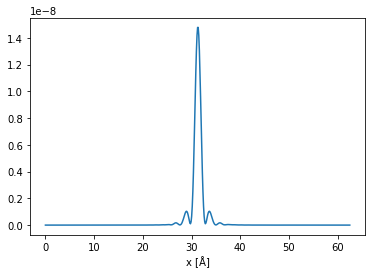

In [19]:
probe.profile().show()

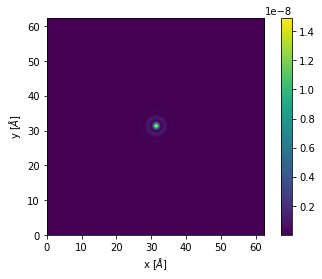

In [20]:
%matplotlib inline
#aperture = DeviatedAnularAperture(aperture_angle=semiangle_cutoff,inner_aperture_angle=0*semiangle_cutoff/2,spokes=0,spoke_thickness=1)
#probe = Probe(energy=energy,aperture=aperture, semiangle_cutoff=semiangle_cutoff, rolloff=0.1, defocus=defocus_0, Cs=aberations_dict["C30"])#, angular_spread=angular_spread,focal_spread=focal_spread)
probe.grid.match(potential)
#%matplotlib qt
im=(np.absolute(fft_shift(probe.build().intensity().array,np.array([0,0]))))[0]
plt.figure()
extent=np.array(probe.grid.gpts)*probe.grid.sampling
imshow(np.swapaxes(im,0,1),extent=(0,extent[0],0,extent[1]))
plt.xlabel(r"x [$\AA$]")
plt.ylabel(r"y [$\AA$]")
plt.colorbar()
plt.show()

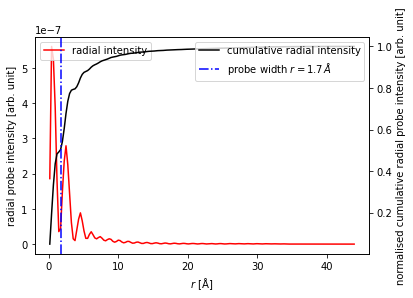

In [21]:
calibration = probe.profile().calibrations[0]
%matplotlib inline
center_indeces=np.unravel_index(im.argmax(),im.shape)
y,x = np.indices((im.shape)) # x and y are in pixels
r = np.sqrt((x-center_indeces[0])**2+(y-center_indeces[1])**2)    

# radius of the image.
r_max = np.max(r)  

ring_brightness, radius_edges = np.histogram(r, weights=im, bins=int(gpts/3))
radius = (radius_edges[1:]+radius_edges[0:-1])/2

fig, ax1 = plt.subplots() 
plt.plot(radius*calibration.sampling, ring_brightness,"r",label="radial intensity")
plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial probe intensity [arb. unit]")
ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial = np.cumsum(ring_brightness)/ring_brightness.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(radius*calibration.sampling,cumulative_radial,"k",label="cumulative radial intensity")
plt.ylabel(r"normalised cumulative radial probe intensity [arb. unit]")
r_half=radius[np.argmin(np.abs(cumulative_radial-0.5))]*calibration.sampling #in A
plt.axvline(x=r_half,color="b",linestyle="-.",label="probe width $r = {:.1f}\,\AA$ ".format(r_half))
ax2.legend(loc=1)
plt.show()

In [22]:
#Autocorrelation of probe 

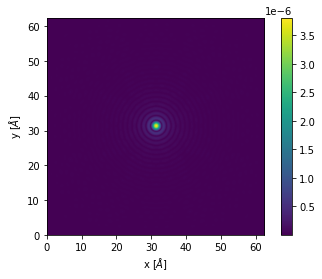

In [23]:
%matplotlib inline
from scipy  import signal
complex_probe_image = probe.build().array[0]

conv = signal.fftconvolve(complex_probe_image,complex_probe_image[::-1,::-1].conjugate(),mode="same")

im=np.abs(conv)

imshow(np.swapaxes(im,0,1),extent=(0,extent[0],0,extent[1]))
plt.xlabel(r"x [$\AA$]")
plt.ylabel(r"y [$\AA$]")
plt.colorbar()


In [24]:
#Radial dependency of autocorrelation:

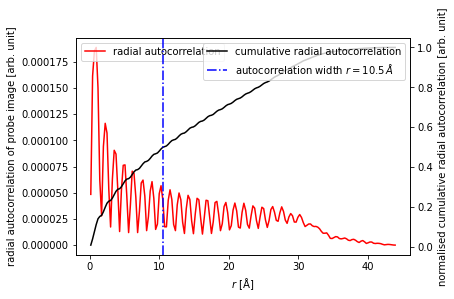

In [25]:
%matplotlib inline
center_indeces=np.unravel_index(im.argmax(),im.shape)
y,x = np.indices((im.shape)) # x and y are in pixels
r = np.sqrt((x-center_indeces[0])**2+(y-center_indeces[1])**2)    

# radius of the image.
r_max = np.max(r)  

ring_brightness, radius_edges = np.histogram(r, weights=im, bins=int(gpts/3))
radius = (radius_edges[1:]+radius_edges[0:-1])/2


fig, ax1 = plt.subplots() 
plt.plot(radius*calibration.sampling, ring_brightness,"r",label="radial autocorrelation")
plt.xlabel(r"$r$ [$\mathrm{\AA}$]")
plt.ylabel(r"radial autocorrelation of probe image [arb. unit]")
ax1.legend(loc=2)

ax2=ax1.twinx()

cumulative_radial = np.cumsum(ring_brightness)/ring_brightness.sum() #relaying on the fact that sampling in position is equidistant
plt.plot(radius*calibration.sampling,cumulative_radial,"k",label="cumulative radial autocorrelation")
plt.ylabel(r"normalised cumulative radial autocorrelation [arb. unit]")
r_half=radius[np.argmin(np.abs(cumulative_radial-0.5))]*calibration.sampling #in A
plt.axvline(x=r_half,color="b",linestyle="-.",label="autocorrelation width $r = {:.1f}\,\AA$ ".format(r_half))
ax2.legend(loc=1)
plt.show()